So we know from Notebook 10 that trying to make it learn one set of logits per batch is good and gets features right.

How can we make the logits consistent over batches?

Will collect the gradients and gumbel selected values after 5 epochs in each mode. The two modes will be the behavior before burn-in and the behavior after mode-in.

Will follow Notebook 10 with slight modifications (described right before). Remember in Notebook 10, we explored behaviors when all the features were real vs when half the features were noise.

In [1]:
import torch


from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

import numpy as np

import matplotlib.pyplot as plt
#from sklearn.manifold import TSNE

#import math

#import gc

from utils import *

from sklearn.preprocessing import MinMaxScaler

from scipy.stats import pearsonr

import seaborn as sns

In [2]:
torch.manual_seed(0)
np.random.seed(0)

In [3]:
# really good results for vanilla VAE on synthetic data with EPOCHS set to 50, 
# but when running locally set to 10 for reasonable run times
n_epochs = 50
batch_size = 64
lr = 0.0001
b1 = 0.9
b2 = 0.999

In [4]:
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

device = torch.device("cuda:0" if cuda else "cpu")
#device = 'cpu'
print("Device")
print(device)

Device
cuda:0


In [5]:
D = 30
N = 5000
z_size = 5

In [6]:
torch.manual_seed(0)
np.random.seed(0)

latent_data = np.random.normal(loc=0.0, scale=1.0, size=N*z_size).reshape(N, z_size)

data_mapper = nn.Sequential(
    nn.Linear(z_size, 2 * z_size, bias=False),
    nn.Tanh(),
    nn.Linear(2 * z_size, D, bias = True),
    nn.ReLU()
).to(device)

data_mapper.requires_grad_(False)

latent_data = Tensor(latent_data)
latent_data.requires_grad_(False)

actual_data = data_mapper(latent_data)


for i in range(5):
    print(torch.sum(actual_data[i,:] != 0))
    
actual_data = actual_data.cpu().numpy()
scaler = MinMaxScaler()
actual_data = scaler.fit_transform(actual_data)

actual_data = Tensor(actual_data)

slices = np.random.permutation(np.arange(actual_data.shape[0]))
upto = int(.8 * len(actual_data))

train_data = actual_data[slices[:upto]]
test_data = actual_data[slices[upto:]]

tensor(19, device='cuda:0')
tensor(12, device='cuda:0')
tensor(18, device='cuda:0')
tensor(14, device='cuda:0')
tensor(14, device='cuda:0')


In [7]:
global_t = 1
logits_changed_loss_lambda = .01

Example of what worked before

In [8]:
vae_gumbel_truncated = VAE_Gumbel_NInsta(D, 100, 20, k = 3*z_size, t = global_t)
vae_gumbel_truncated.to(device)
vae_gumbel_trunc_optimizer = torch.optim.Adam(vae_gumbel_truncated.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))

In [9]:
gradients_before_burnin = torch.zeros(train_data.shape[1]).to(device)
gradient_post_burn_in = torch.zeros(train_data.shape[1]).to(device)

for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients(train_data, vae_gumbel_truncated, 
                                                      vae_gumbel_trunc_optimizer, 
                                                      epoch, 
                                                      batch_size, 
                                                      Dim = int(D/2))
    if epoch > 5 and epoch <25:
        gradients_before_burnin += grads
    if epoch == 25:
        with torch.no_grad():
            # collect a version of the select keys at this point
            w = vae_gumbel_truncated.weight_creator(test_data[0:10, :])
            subset_indices_before_burnin = sample_subset(w, k=3*z_size, t=0.01).cpu()
        
        vae_gumbel_truncated.t /= 10
    if epoch > 24:
        gradient_post_burn_in += grads
        
with torch.no_grad():
    w = vae_gumbel_truncated.weight_creator(test_data[0:10, :])
    subset_indices_post_burnin = sample_subset(w, k=3*z_size, t=0.01).cpu()

Train Epoch: 1 [0/4000 (0%)]	Loss: 10.297486
Train Epoch: 1 [1280/4000 (32%)]	Loss: 9.840182
Train Epoch: 1 [2560/4000 (64%)]	Loss: 9.418898
Train Epoch: 1 [3840/4000 (96%)]	Loss: 8.914977
====> Epoch: 1 Average loss: 9.6234
Train Epoch: 2 [0/4000 (0%)]	Loss: 8.954686
Train Epoch: 2 [1280/4000 (32%)]	Loss: 8.584979
Train Epoch: 2 [2560/4000 (64%)]	Loss: 8.056874
Train Epoch: 2 [3840/4000 (96%)]	Loss: 7.609637
====> Epoch: 2 Average loss: 8.3221
Train Epoch: 3 [0/4000 (0%)]	Loss: 7.672081
Train Epoch: 3 [1280/4000 (32%)]	Loss: 7.240375
Train Epoch: 3 [2560/4000 (64%)]	Loss: 7.165366
Train Epoch: 3 [3840/4000 (96%)]	Loss: 6.891551
====> Epoch: 3 Average loss: 7.2920
Train Epoch: 4 [0/4000 (0%)]	Loss: 6.943859
Train Epoch: 4 [1280/4000 (32%)]	Loss: 7.022769
Train Epoch: 4 [2560/4000 (64%)]	Loss: 6.758886
Train Epoch: 4 [3840/4000 (96%)]	Loss: 7.039759
====> Epoch: 4 Average loss: 6.8681
Train Epoch: 5 [0/4000 (0%)]	Loss: 6.857256
Train Epoch: 5 [1280/4000 (32%)]	Loss: 6.786737
Train Epoch

Train Epoch: 37 [1280/4000 (32%)]	Loss: 5.806136
Train Epoch: 37 [2560/4000 (64%)]	Loss: 5.430903
Train Epoch: 37 [3840/4000 (96%)]	Loss: 5.786016
====> Epoch: 37 Average loss: 5.7294
Train Epoch: 38 [0/4000 (0%)]	Loss: 5.870984
Train Epoch: 38 [1280/4000 (32%)]	Loss: 5.877920
Train Epoch: 38 [2560/4000 (64%)]	Loss: 6.049587
Train Epoch: 38 [3840/4000 (96%)]	Loss: 5.562053
====> Epoch: 38 Average loss: 5.7009
Train Epoch: 39 [0/4000 (0%)]	Loss: 5.618323
Train Epoch: 39 [1280/4000 (32%)]	Loss: 5.704149
Train Epoch: 39 [2560/4000 (64%)]	Loss: 5.811220
Train Epoch: 39 [3840/4000 (96%)]	Loss: 5.576554
====> Epoch: 39 Average loss: 5.6886
Train Epoch: 40 [0/4000 (0%)]	Loss: 5.687874
Train Epoch: 40 [1280/4000 (32%)]	Loss: 5.467231
Train Epoch: 40 [2560/4000 (64%)]	Loss: 5.677130
Train Epoch: 40 [3840/4000 (96%)]	Loss: 5.808716
====> Epoch: 40 Average loss: 5.6727
Train Epoch: 41 [0/4000 (0%)]	Loss: 5.898568
Train Epoch: 41 [1280/4000 (32%)]	Loss: 5.530208
Train Epoch: 41 [2560/4000 (64%)]	L

tensor(8834.4951, device='cuda:0')
tensor(4798.3896, device='cuda:0')


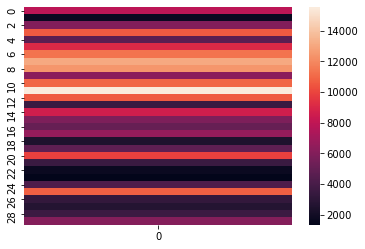

In [10]:
print(gradients_before_burnin[:(D//2)].mean())
print(gradients_before_burnin[(D//2):].mean())
sns.heatmap(gradients_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])


tensor(26189.5840, device='cuda:0')
tensor(11740.6943, device='cuda:0')


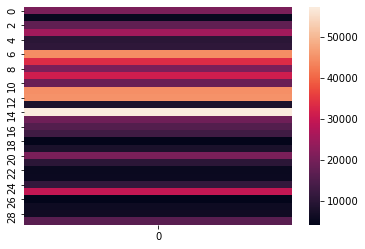

In [11]:
print(gradient_post_burn_in[:(D//2)].mean())
print(gradient_post_burn_in[(D//2):].mean())
sns.heatmap(gradient_post_burn_in.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(5.5734)
tensor(4.4266)


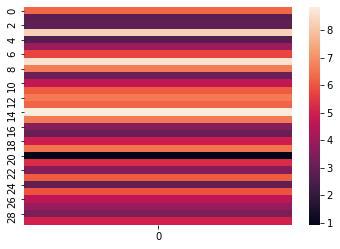

In [12]:
print(subset_indices_before_burnin.sum(dim = 0)[:(D//2)].mean())
print(subset_indices_before_burnin.sum(dim = 0)[(D//2):].mean())
sns.heatmap(subset_indices_before_burnin.sum(dim = 0).clone().detach().cpu().numpy()[:, np.newaxis])

tensor(5.7758)
tensor(4.2242)


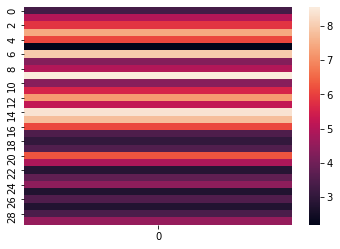

In [13]:
print(subset_indices_post_burnin.sum(dim = 0)[:(D//2)].mean())
print(subset_indices_post_burnin.sum(dim = 0)[(D//2):].mean())
sns.heatmap(subset_indices_post_burnin.sum(dim = 0).clone().detach().cpu().numpy()[:, np.newaxis])

In [14]:
subset_indices_post_burnin.sum(dim = 0)[:(D//2)].sum() - subset_indices_post_burnin.sum(dim = 0)[(D//2):].sum()

tensor(23.2755)

The new model


In [27]:
logits_changed_loss_lambda = 5
alpha = 0.99

In [28]:
vae_gumbel_truncated = VAE_Gumbel_NInstaState(D, 100, 20, k = 3*z_size, t = global_t, alpha = alpha)
vae_gumbel_truncated.to(device)
vae_gumbel_trunc_optimizer = torch.optim.Adam(vae_gumbel_truncated.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))



In [29]:
gradients_before_burnin = torch.zeros(train_data.shape[1]).to(device)
gradient_post_burn_in = torch.zeros(train_data.shape[1]).to(device)

for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients_gumbel_state(train_data, vae_gumbel_truncated, 
                                                      vae_gumbel_trunc_optimizer, 
                                                      epoch, 
                                                      batch_size, 
                                                      Dim = int(D/2),
                                                      logits_changed_loss_lambda=logits_changed_loss_lambda,
                                                      DEBUG = True)
    if epoch > 5 and epoch <25:
        gradients_before_burnin += grads
    if epoch == 25:
        with torch.no_grad():
            # collect a version of the select keys at this point
            print("GUMBEL DEBUG")
            w = vae_gumbel_truncated.weight_creator(test_data[0:10, :])
            subset_indices_before_burnin = sample_subset(w, k=3*z_size, t=0.01).cpu()
        
        print("BURN IN DEBUG")
        vae_gumbel_truncated.set_burned_in()
        #vae_gumbel_truncated.t /= 10
        print("Going post burn in")
    if epoch > 24:
        gradient_post_burn_in += grads
        
with torch.no_grad():
    w = vae_gumbel_truncated.weight_creator(test_data[0:10, :])
    subset_indices_post_burnin = sample_subset(w, k=3*z_size, t=0.01).cpu()

Train Epoch: 1 [0/4000 (0%)]	Loss: 10.623770
Train Epoch: 1 [1280/4000 (32%)]	Loss: 39.467003
Train Epoch: 1 [2560/4000 (64%)]	Loss: 104.211182
Train Epoch: 1 [3840/4000 (96%)]	Loss: 189.626465
====> Epoch: 1 Average loss: 84.3974
Train Epoch: 2 [0/4000 (0%)]	Loss: 201.423218
Train Epoch: 2 [1280/4000 (32%)]	Loss: 284.658203
Train Epoch: 2 [2560/4000 (64%)]	Loss: 366.962280
Loss tensor(509.5094, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(5341.9512, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 2 [3840/4000 (96%)]	Loss: 442.345276
====> Epoch: 2 Average loss: 330.9676
Train Epoch: 3 [0/4000 (0%)]	Loss: 453.206390
Train Epoch: 3 [1280/4000 (32%)]	Loss: 517.777832
Train Epoch: 3 [2560/4000 (64%)]	Loss: 586.978394
Train Epoch: 3 [3840/4000 (96%)]	Loss: 652.714783
====> Epoch: 3 Average loss: 559.6708
Train Epoch: 4 [0/4000 (0%)]	Loss: 653.955811
Train Epoch: 4 [1280/4000 (32%)]	Loss: 678.346069
Train Epoch: 4 [2560/4000 (64%)]	Loss: 708.906067
Loss tensor(434.106

Train Epoch: 27 [1280/4000 (32%)]	Loss: 6.034740
Train Epoch: 27 [2560/4000 (64%)]	Loss: 6.061625
Train Epoch: 27 [3840/4000 (96%)]	Loss: 5.791340
====> Epoch: 27 Average loss: 6.0410
Train Epoch: 28 [0/4000 (0%)]	Loss: 6.002451
Train Epoch: 28 [1280/4000 (32%)]	Loss: 5.887885
Train Epoch: 28 [2560/4000 (64%)]	Loss: 5.956537
Loss tensor(381.2927, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 28 [3840/4000 (96%)]	Loss: 5.984483
====> Epoch: 28 Average loss: 5.9996
Train Epoch: 29 [0/4000 (0%)]	Loss: 5.984958
Train Epoch: 29 [1280/4000 (32%)]	Loss: 5.820328
Train Epoch: 29 [2560/4000 (64%)]	Loss: 5.938360
Train Epoch: 29 [3840/4000 (96%)]	Loss: 5.949363
====> Epoch: 29 Average loss: 5.9724
Train Epoch: 30 [0/4000 (0%)]	Loss: 5.840473
Train Epoch: 30 [1280/4000 (32%)]	Loss: 5.824463
Loss tensor(374.1205, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 30 [2560/4000 (64%)]	Loss: 6.229754
Train Epoch: 30 [3840/4000 (96%)]	Loss: 5.879240
====> Epoch: 3

tensor(1655545.8750, device='cuda:0')
tensor(1543199.1250, device='cuda:0')


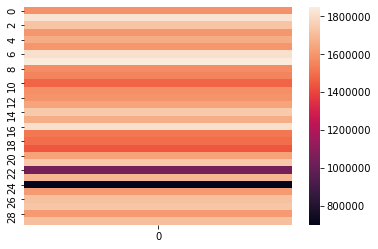

In [30]:
print(gradients_before_burnin[:(D//2)].mean())
print(gradients_before_burnin[(D//2):].mean())
sns.heatmap(gradients_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])


tensor(30415.0176, device='cuda:0')
tensor(22756.5898, device='cuda:0')


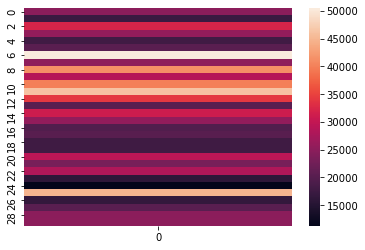

In [31]:
print(gradient_post_burn_in[:(D//2)].mean())
print(gradient_post_burn_in[(D//2):].mean())
sns.heatmap(gradient_post_burn_in.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(5.9114)
tensor(4.0886)


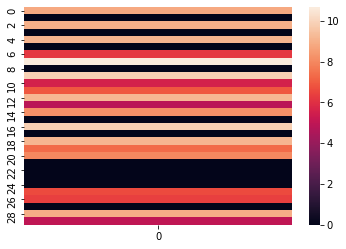

In [32]:
print(subset_indices_before_burnin.sum(dim = 0)[:(D//2)].mean())
print(subset_indices_before_burnin.sum(dim = 0)[(D//2):].mean())
sns.heatmap(subset_indices_before_burnin.sum(dim = 0).clone().detach().cpu().numpy()[:, np.newaxis])

tensor(6.2770)
tensor(3.7230)


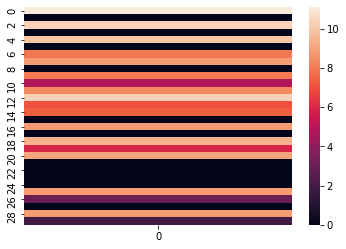

In [33]:
print(subset_indices_post_burnin.sum(dim = 0)[:(D//2)].mean())
print(subset_indices_post_burnin.sum(dim = 0)[(D//2):].mean())
sns.heatmap(subset_indices_post_burnin.sum(dim = 0).clone().detach().cpu().numpy()[:, np.newaxis])

In [34]:
(subset_indices_post_burnin.sum(dim = 0)[:(D//2)] > 0).sum()

tensor(11)

In [35]:
(subset_indices_post_burnin.sum(dim = 0)[(D//2):] > 0).sum()

tensor(8)

In [36]:
subset_indices_post_burnin.sum(dim = 0)[:(D//2)]

tensor([11.0880,  0.0000, 10.3270,  0.0000,  9.9989,  0.0000,  7.9473,  8.8751,
         0.0000,  7.9791,  4.8129,  8.3647, 10.3226,  7.0781,  7.3608])

In [37]:
subset_indices_post_burnin.sum(dim = 0)[(D//2):]

tensor([0.0000, 8.8294, 0.0000, 9.4481, 5.9344, 9.0839, 0.0000, 0.0000, 0.0000,
        0.0000, 8.7959, 3.0003, 0.0000, 8.8450, 1.9086])

In [38]:
subset_indices_post_burnin.sum(dim = 0)[:(D//2)].sum() - subset_indices_post_burnin.sum(dim = 0)[(D//2):].sum()

tensor(38.3089)